<div style="text-align: center;">
    <h1>NAIVE BAYES MODEL FOR SENTIMENT ANALYSIS</h1>
</div>


### IMPORTING LIBRARIES

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem import PorterStemmer
nltk.download('punkt')
from nltk.corpus import stopwords
import string

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/gautam/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/gautam/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### GETTING DATA

In [30]:
df = pd.read_csv('./Twitter_Data/twitter.csv')

df.shape

(74681, 4)

In [31]:
df.columns

Index(['2401', 'Borderlands', 'Positive',
       'im getting on borderlands and i will murder you all ,'],
      dtype='object')

In [32]:
df.columns=['id','category','sentiment','tweet']
df = df.dropna(subset=['tweet'])
df.shape

(73995, 4)

### VISUALIZING DATA

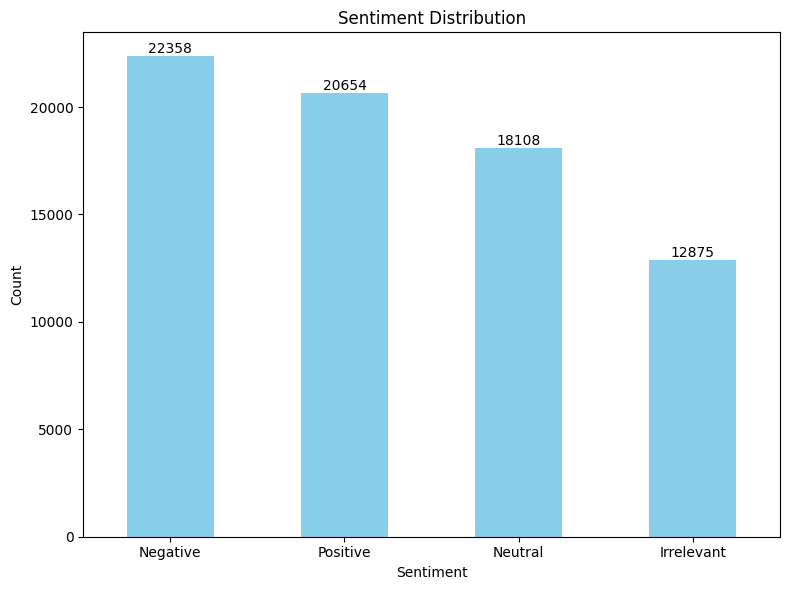

In [33]:

# Getting the value counts
sentiment_counts = df['sentiment'].value_counts()

# Plotting the value counts
plt.figure(figsize=(8, 6))
ax = sentiment_counts.plot(kind='bar', color='skyblue')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')

# Display counts on top of each bar
for i, count in enumerate(sentiment_counts):
    ax.text(i, count + 5, str(count), ha='center', va='bottom')

plt.xticks(rotation=0)  # Rotate x-axis labels for better readability if needed
plt.tight_layout()
plt.show()

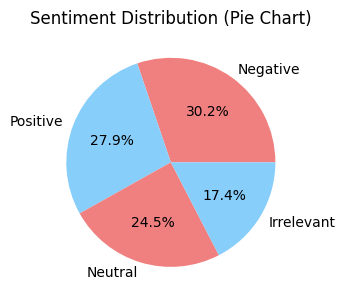

In [34]:
plt.subplot(1, 2, 2)
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', colors=['lightcoral', 'lightskyblue'])
plt.title('Sentiment Distribution (Pie Chart)')

plt.tight_layout()
plt.show()

### DATA PREPROCESSING

In [35]:

# Function to replace numbers with placeholders based on their length
def clean_numbers(text):
    if bool(re.search(r'\d', text)):
        text = re.sub('[0-9]{5,}', '#####', text)
        text = re.sub('[0-9]{4}', '####', text)
        text = re.sub('[0-9]{3}', '###', text)
        text = re.sub('[0-9]{2}', '##', text)

    return text

# Function to remove consecutive hash symbols
def remove_hash(text):
      text = re.sub(r'#{1,}', '', text)
      return text

# Function to remove URLs
def remove_urls(text):
      text = re.sub(r'https?://[^\s\n\r]+', '', text)
      return text

# Function to preprocess a tweet by removing special characters, URLs, hashtags,
# tokenizing, stemming, removing stopwords, and punctuation
def preprocess_tweet(tweet):
    stemmer = PorterStemmer()
    stopwords_english = stopwords.words('english')

    tweet = re.sub(r'\$\w*', '', tweet) # Removing stock market tickers like $AAPL
    tweet = re.sub(r'^RT[\s]+', '', tweet) # Removing RT (retweet) tags
    tweet = clean_numbers(tweet) # Calling clean_numbers function to replace numbers with placeholders
    tweet = remove_urls(tweet) # Calling remove_urls function to remove URLs
    tweet = remove_hash(tweet) # Calling remove_hash function to remove consecutive hash symbols
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True,
                               reduce_len=True)
    tweet_tokens = tokenizer.tokenize(tweet) # Tokenizing the tweet text

    tweets_clean = []
    for word in tweet_tokens:
        if (word not in stopwords_english and
                word not in string.punctuation):
            stem_word = stemmer.stem(word)
            tweets_clean.append(stem_word)

    return tweets_clean

In [36]:
df.loc[:, 'prep'] = df['tweet'].apply(preprocess_tweet) # Appending a new column to dataframe prep

In [37]:
df.rename(columns={'prep':'preprocessed_tweet'}, inplace=True) # renaming prep tp preprocessed_tweet
df.head()

,id,category,sentiment,tweet,preprocessed_tweet
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...,"[come, border, kill]"
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...,"[im, get, borderland, kill]"
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...,"[im, come, borderland, murder]"
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...,"[im, get, borderland, 2, murder]"
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...,"[im, get, borderland, murder]"


In [38]:
# Mapping sentiment labels to numerical values using a dictionary
sentiment_mapping = {
    'Positive': 1,
    'Negative': 2,
    'Neutral': 3,
    'Irrelevant': 3
}

# Mapping the 'sentiment' column in the 'df' DataFrame to numerical labels using the 'sentiment_mapping' dictionary
df.loc[:, 'label'] = df['sentiment'].map(sentiment_mapping)

# Displaying the value counts of the 'label' column to show the distribution of the mapped labels
label_value_counts = df.label.value_counts()
print(label_value_counts)


label
3    30983
2    22358
1    20654
Name: count, dtype: int64


In [39]:
def count_tweets(result, tweets, ys):
    # Iterate through each tweet and corresponding sentiment label
    for y, tweet in zip(ys, tweets):
        # Tokenize and preprocess each word in the tweet
        for word in preprocess_tweet(tweet):
            pair = (word, y)  # Create a word-sentiment label pair

            # Check if the word-sentiment pair exists in the result dictionary
            if pair in result:
                result[pair] += 1  # Increment the count for the existing pair
            else:
                result[pair] = 1  # Initialize the count for a new pair

    return result  # Return the updated dictionary with word-sentiment pairs and their counts


In [40]:
result = dict()
frequency = count_tweets({}, df['tweet'], df['label'])

In [41]:
from sklearn.model_selection import train_test_split

### SPLITTING DATA INTO TRAIN_TEST

In [42]:
X_train, X_test, y_train, y_test = train_test_split(df['tweet'],df['label'], test_size = 0.2)

In [43]:
X_train.shape

(59196,)

In [44]:
X_test.shape

(14799,)

In [45]:
y_train.shape

(59196,)

In [46]:
y_test.shape

(14799,)

### DEFINING NAIVE BAYES FUNCTION FOR TRAINING

In [47]:
def train_naive_bayes(freqs, train_x, train_y):

    # Initialize dictionaries to store log-likelihoods and log-priors
    loglikelihoods = {}
    logpriors = {}

    # Extract unique words (vocabulary) from the frequencies dictionary
    vocab = set([key[0] for key in freqs.keys()])
    V = len(vocab)  # Total number of unique words in the vocabulary

    # For each unique sentiment label in the training set
    for label in set(train_y):
        # Calculate total word count and count of words that appear at least once for the given label
        N_label = sum(freqs.get((word, label), 0) for word in vocab)
        V_label = len([word for word in vocab if freqs.get((word, label), 0) > 0])

        # Calculate total count of the given label in the training set
        D_label = sum(1 for l in train_y if l == label)

        # Compute log-priors: log(D_label / total number of training samples)
        logpriors[label] = np.log(D_label / len(train_y))

        # Compute log-likelihoods for each word given the label
        for word in vocab:
            freq_label = freqs.get((word, label), 0)

            # Compute smoothed probability: (freq_label + 1) / (N_label + total unique words)
            p_w_label = (freq_label + 1) / (N_label + V)

            # Store log of the smoothed probability as log-likelihood
            if word not in loglikelihoods:
                loglikelihoods[word] = {}
            loglikelihoods[word][label] = np.log(p_w_label)

    return logpriors, loglikelihoods


In [48]:
logprior, loglikelihood = train_naive_bayes(frequency, X_train, y_train) # Getting logprior and likelihood based on training Data
print(logprior)
print(len(loglikelihood))

{1: -1.277857293628438, 2: -1.1937096389025097, 3: -0.8716245242232061}
31293


### FUNCTION FOR PREDICTING SENTIMENT

In [49]:
def naive_bayes_predict(tweet, logprior, loglikelihood):
    # Preprocess the tweet before prediction
    processed_tweet = preprocess_tweet(tweet)

    # Create a copy of logprior to store probabilities
    probability = logprior.copy()

    # Iterate through each word in the processed tweet
    for word in processed_tweet:
        # Check if the word exists in loglikelihood and has associated probabilities
        if word in loglikelihood and loglikelihood[word]:
            # For each label and associated log likelihood for the word
            for label, log_likelihood in loglikelihood[word].items():
                # Update the probability for each label by adding the log likelihood
                probability[label] += log_likelihood

    # Determine the label with the highest probability
    predicted_label = max(probability, key=probability.get)

    return predicted_label


In [50]:
# Dict to get back original mapping based on predicted number
get_sentiment = {
    1: 'Positive',
    2: 'Negative',
    3: 'Nuetral',
}

In [51]:
# Testing a random sample
tweet = 'I have listened to music over and over again, it is mesmerizing.'
label = naive_bayes_predict(tweet, logprior, loglikelihood)
print(get_sentiment[label])

Positive


In [52]:
# Testing a random sample
tweet = 'It is very bad, pathetic, this is not acceptable'
label = naive_bayes_predict(tweet, logprior, loglikelihood)
print(get_sentiment[label])

Negative


### DEINFING FUNCTION TO TEST THE ACCURACY

In [53]:
def test_acc(test_x, test_y, logprior, loglikelihood):
    # Generate predicted labels for each tweet in the test set using Naive Bayes prediction function
    predicted_labels = [naive_bayes_predict(tweet, logprior, loglikelihood) for tweet in test_x]
    
    # Count the number of correct predictions by comparing predicted labels with true labels
    correct_predictions = sum(1 for pred, true_label in zip(predicted_labels, test_y) if pred == true_label)
    
    # Calculate accuracy by dividing the number of correct predictions by the total number of samples
    accuracy = correct_predictions / len(test_y)
    
    # Return the accuracy of the Naive Bayes classifier on the test set
    return accuracy, predicted_labels

In [54]:
train_acc, train_pred = test_acc(X_train,y_train,logprior,loglikelihood) # Getting accuracy on Train Data
print(f"Train Accuracy: {train_acc*100:.2f}")

Train Accuracy: 78.42


In [55]:
test_accuracy, test_pred = test_acc(X_test, y_test, logprior, loglikelihood) # Getting accuracy on Test Data
print(f"Test Accuracy: {test_accuracy*100:.2f}")

Test Accuracy: 78.78


### VISUALIZING THE MODEL METRICS

In [56]:
from sklearn.metrics import confusion_matrix, classification_report
from tabulate import tabulate


# Calculate the confusion matrix
cm = confusion_matrix(y_test, test_pred)

# Define class labels for better visualization (e.g., 'positive', 'negative', 'neutral', 'irrelevant')
class_labels = ['Actual_Positive', 'Actual_Negative', 'Actual_Neutral']
pred_labels = ['Predicted_Positive', 'Predicted_Negative', 'Predicted_Neutral']

# Create the confusion matrix table using tabulate
confusion_matrix_table = tabulate(cm, headers=class_labels, showindex=pred_labels, tablefmt='grid')

# Print the confusion matrix
print("Confusion Matrix:")
print(confusion_matrix_table)

print('\n\n',classification_report(y_test, test_pred))

Confusion Matrix:
+--------------------+-------------------+-------------------+------------------+
|                    |   Actual_Positive |   Actual_Negative |   Actual_Neutral |
+====================+===================+===================+==================+
| Predicted_Positive |              3274 |               345 |              541 |
+--------------------+-------------------+-------------------+------------------+
| Predicted_Negative |               292 |              3596 |              528 |
+--------------------+-------------------+-------------------+------------------+
| Predicted_Neutral  |               738 |               696 |             4789 |
+--------------------+-------------------+-------------------+------------------+


               precision    recall  f1-score   support

           1       0.76      0.79      0.77      4160
           2       0.78      0.81      0.79      4416
           3       0.82      0.77      0.79      6223

    accuracy           